### Import library

In [1]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup as bs #tweets coded in xml format
import random
import tensorflow as tf
import tensorflow_hub as hub #download bert weights
from tensorflow.keras import layers
import bert #from bert-for-tf2
import matplotlib.pyplot as plt
import seaborn as sns
import os

### Read & Clean data

In [2]:
col = ['sentiment', 'id', 'date', 'query', 'user', 'text']
data = pd.read_csv(r'trainingandtestdata\training.1600000.processed.noemoticon.csv',
                   header = None,
                   names = col, 
                   engine = 'python', 
                  encoding='latin1')

In [3]:
data.drop(['id', 'date', 'query', 'user'],
         axis = 1, 
         inplace = True)

In [4]:
data.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [5]:
data.describe()

,sentiment
count,1.600000e+06
mean,2.000000e+00
std,2.000001e+00
min,0.000000e+00
25%,0.000000e+00
50%,2.000000e+00
75%,4.000000e+00
max,4.000000e+00


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   text       1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [7]:
data.sentiment.value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='sentiment', ylabel='count'>

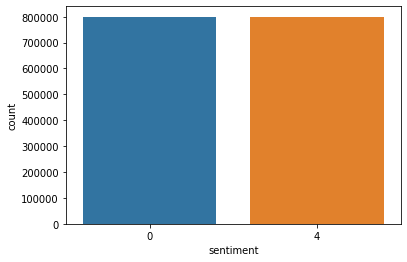

In [8]:
sns.countplot(x='sentiment', data=data)

In [9]:
data.isnull().sum()

sentiment    0
text         0
dtype: int64

In [10]:
def clean_tweet(tweet):
    tweet = bs(tweet, 'lxml').get_text() #use bs to get lxml encdoed string into standard string
    tweet = re.sub(r'@[A-Za-z0-9]+', ' ', tweet)
    tweet = re.sub(r'https?://[A-Za-z0-9]+', ' ', tweet) #replace http or https
    tweet = re.sub(r'^[a-zA-Z.!?]', ' ', tweet) #remove non-alph and punct
    tweet = re.sub(r' +', ' ', tweet) #replace more than 1 space with 1 space
    return tweet

In [11]:
data_clean = [clean_tweet(tweet) for tweet in data.text]

C:\Users\KX764QE\Anaconda3\envs\courses\lib\site-packages\bs4\__init__.py:336: MarkupResemblesLocatorWarning: " i just received my G8 viola exam.. and its... well... .. disappointing.. :\.." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning
C:\Users\KX764QE\Anaconda3\envs\courses\lib\site-packages\bs4\__init__.py:336: MarkupResemblesLocatorWarning: "E3 ON PLAYSTATION HOME IN ABOUT AN HOUR!!!!!!!!!! \../  \../" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


In [12]:
data_labels = data.sentiment.values #set as numpy array
data_labels[data_labels == 4] = 1 #make label 4 to 1

### Tokenization

create a bert layer to have acess to meta data for the tokenzier

In [13]:
FullTokenizer = bert.bert_tokenization.FullTokenizer

In [14]:
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/3', #model link
                           trainable= False, #set it untrainable, only get tokenizer info
                           )

below save the voab file (.text) to local Temp folder

In [15]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy() #to have access to the vocab file

In [16]:
vocab_file

b'C:\\Users\\KX764QE\\AppData\\Local\\Temp\\tfhub_modules\\df193a19db0ae0829dfb5ebf3c73f418ccbc921c\\assets\\vocab.txt'

do_lower_case, a variable that is related to the Bert layer  
don't have to change the code if we use a different Bert layer

In [17]:
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [18]:
do_lower_case

True

In [21]:
local_vocab_file = r'C:\Users\KX764QE\Documents\Learn Bert-most powerful NLP algorithm by Google\vocab.txt'

In [22]:
tokenizer = FullTokenizer(local_vocab_file, do_lower_case)

if the word is not in the vocab ("raspberry" for instance), the tokeniser will try to split it with known words. So it recognises "berry" and is left with "rasp", which it doesn't have in its vocabulary. 

In [23]:
tokenizer.tokenize('my dog loves strawberries')

['my', 'dog', 'loves', 'straw', '##berries']

In [24]:
tokenizer.tokenize('my dog loves raspberries')

['my', 'dog', 'loves', 'ras', '##p', '##berries']

In [25]:
tokenizer.convert_tokens_to_ids(tokenizer.tokenize('my dog loves strawberries'))

[2026, 3899, 7459, 13137, 20968]

In [26]:
def encode_sent(sent):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sent))

In [27]:
data_inputs = [encode_sent(sentence) for sentence in data_clean]

### Data creation

 - padding: add padding tokens to the end of each sentence, so their length are the same
 - instead of padding each sentence, we pad each batch. With each batch, sentences are padded to have the same length.
 - no need to make each batch with the same length

In [28]:
data_with_len = [[sent, data_labels[i], len(sent)] 
                 for i, sent in enumerate(data_inputs)]

#inital data are sorted with 0 first and 1
#we need each batch to have random labels
random.shuffle(data_with_len)
#sort sent by length
#if without shuffling, for each sent length, we get all negative sents bef positive sents
data_with_len.sort(key = lambda x: x[2]) 

#remove length, and keep tweets longer than 7
sorted_all = [(sent_lab[0], sent_lab[1]) for 
              sent_lab in data_with_len if sent_lab[2] > 7]

In [29]:
len(sorted_all)

1366538

In [30]:
sorted_all[200]

([1045, 6135, 2342, 2000, 2131, 2009, 2059, 999], 1)

In [31]:
all_dataset = tf.data.Dataset.from_generator(lambda: sorted_all, #use lambda as a genrator
                                            output_types = (tf.int32, tf.int32)) #type for label and id

In [32]:
all_dataset

<FlatMapDataset shapes: (<unknown>, <unknown>), types: (tf.int32, tf.int32)>

In [33]:
next(iter(all_dataset))

(<tf.Tensor: shape=(8,), dtype=int32, numpy=array([10201, 11867,  5686,  1998,  3666, 20052,  9106,  1012])>,
 <tf.Tensor: shape=(), dtype=int32, numpy=1>)

In [34]:
BATCH_SIZE = 32
all_batched = all_dataset.padded_batch(BATCH_SIZE, padded_shapes = ((None, ), ()))

In [35]:
all_batched

<PaddedBatchDataset shapes: ((None, None), (None,)), types: (tf.int32, tf.int32)>

In [36]:
next(iter(all_batched))

(<tf.Tensor: shape=(32, 8), dtype=int32, numpy=
 array([[10201, 11867,  5686,  1998,  3666, 20052,  9106,  1012],
        [19875,  2073,  2003,  4698,  2043,  1045,  2342,  2014],
        [28774, 11365,  5937,  2015,   999,  5959,  2115,  4157],
        [ 2748,   999,   999,  1045,  2052,  2293,  2000,   999],
        [ 1055,  4439,  2083, 16631, 10261,  2016,  2071,  2644],
        [ 1056,  3190,  1996,  2377,  1999,  3994,  2061,  2204],
        [ 2092,  2123,  1005,  1056,  2147,  2205,  2524,   999],
        [ 2293,  4402,  2017, 10933,   999,  2643, 19994,  2017],
        [16717,  2061, 24927,  1012,  4012,  5292,  3270,  1012],
        [ 1035,  2008,  2015,  2522,  2480,  2057,  2293,  2017],
        [ 2123,  2102,  2514,  2200,  1000, 27420,  1000,  3892],
        [24471,  2157,  1011, 10047,  2108, 13971,  2295,  1011],
        [24471,  3372,  2026,  4416,  2006, 29593,  8246,  1012],
        [25212,  3436,  2007,  2132,  1997,  2095,  4826,   999],
        [15068,  4364,  2031

In [37]:
NB_BATCHES = math.ceil(len(sorted_all)/BATCH_SIZE)
#use 10th for testing
NB_BATCHES_TEST = NB_BATCHES//10 
#need to shuffle the batches
all_batched.shuffle(NB_BATCHES) #for a total shuffle, buffer-size needs to greater the full size of dataset

test_dataset = all_batched.take(NB_BATCHES_TEST)
train_dataset = all_batched.skip(NB_BATCHES_TEST)

In [38]:
next(iter(test_dataset))

(<tf.Tensor: shape=(32, 8), dtype=int32, numpy=
 array([[10201, 11867,  5686,  1998,  3666, 20052,  9106,  1012],
        [19875,  2073,  2003,  4698,  2043,  1045,  2342,  2014],
        [28774, 11365,  5937,  2015,   999,  5959,  2115,  4157],
        [ 2748,   999,   999,  1045,  2052,  2293,  2000,   999],
        [ 1055,  4439,  2083, 16631, 10261,  2016,  2071,  2644],
        [ 1056,  3190,  1996,  2377,  1999,  3994,  2061,  2204],
        [ 2092,  2123,  1005,  1056,  2147,  2205,  2524,   999],
        [ 2293,  4402,  2017, 10933,   999,  2643, 19994,  2017],
        [16717,  2061, 24927,  1012,  4012,  5292,  3270,  1012],
        [ 1035,  2008,  2015,  2522,  2480,  2057,  2293,  2017],
        [ 2123,  2102,  2514,  2200,  1000, 27420,  1000,  3892],
        [24471,  2157,  1011, 10047,  2108, 13971,  2295,  1011],
        [24471,  3372,  2026,  4416,  2006, 29593,  8246,  1012],
        [25212,  3436,  2007,  2132,  1997,  2095,  4826,   999],
        [15068,  4364,  2031

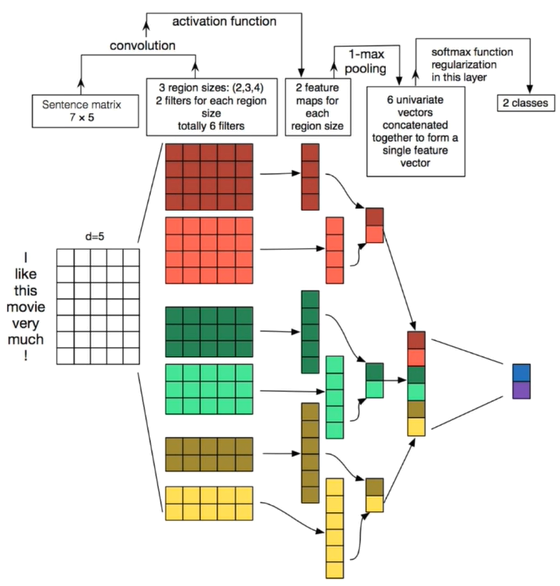

Three different inputs ((token, segment and position)) that we give to BERT is just a choice that has been made by the creators of the specific BERT model we are using.  
It helps the model to understand more precisely our input sentence.  
the [ids, mask, segment] that we give as input for our model will help the BERT layer to compute [token, segment, position] that it uses for the rest of the process.

For example, if the length of the input sentence is 200, then it is a must to pad the sentence with 0's. The padding length will be = Maximum input length - Sentence length = 512 - 200 = 312.

If your sentence length is above 512 tokens including the special tokens, then you should truncate the sentence to a fixed length ( maximum length).



Why the special token [CLS] not added?  

The way the BERT layer has been built is that we just need to send our standard tokenised sentence (without adding a token at the beginning) and we will get two outputs: a single vector (corresponding to the CLS token) and a sequence of vectors (corresponding to each of the tokens of our sentence). If you prefer, you can think of it as if the BERT layer takes care of adding the CLS token by itself.

### Model creation

In [67]:
#inherit Model class
class DCNN(tf.keras.Model):
    def __init__(self, 
                 vocab_size, 
                 emb_dim = 128, 
                 nb_filters = 50, #number of filters
                 FFN_units = 512, #hidden units for dense layer
                 nb_classes = 2, #numb of classes
                 dropout_rate = 0.1, 
                 training = False, 
                name = 'dcnn'):
        #--use init method from tf.keras.Model
        super(DCNN, self).__init__(name = name)
        
        self.embedding = layers.Embedding(vocab_size, emb_dim) #embedding token ID to be trained
        #--only shift vertifically, use 1D
        self.bigram = layers.Conv1D(filters = nb_filters, #foucs on 2 conceutive words
                                    kernel_size = 2,
                                    padding = 'valid',
                                    activation = 'relu')
        self.trigram = layers.Conv1D(filters = nb_filters, #foucs on 3 conceutive words
                                    kernel_size = 3,
                                    padding = 'valid',
                                    activation = 'relu')
        self.fourgram = layers.Conv1D(filters = nb_filters, #foucs on 4 conceutive words
                                    kernel_size = 4,
                                    padding = 'valid',
                                    activation = 'relu') #remove negative val
        
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units = FFN_units,
                                    activation = 'relu')
        
        self.dropout = layers.Dropout(rate = dropout_rate)
        
        if nb_classes == 2:
            self.last_dense = layers.Dense(units = 1, activation = 'sigmoid')
        else:
            self.last_dense = layers.Dense(units = nb_classes, activation = 'softmax')
    
    #--training: train or not, if training use dropuout; if prediction, no dropput
    def call(self, inputs, training):
        x = self.embedding(inputs)
        
        x_1= self.bigram(x)
        x_1 = self.pool(x_1) #(batch size, 50), each filter generates 1 feature
        
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3) #(batch_szie, nb_filters)
        
        merged = tf.concat([x_1, x_2, x_3], axis = -1) #(batch_size, nb_filters*3)
        
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)
        
        return output        

### Model Training

In [68]:
VOCAB_SIZE = len(tokenizer.vocab)
EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 2
DROPOUT_RATE = 0.2

NB_EPOCHS = 5

In [69]:
dcnn = DCNN(vocab_size = VOCAB_SIZE,
            emb_dim = EMB_DIM,
            nb_filters = NB_FILTERS, #number of filters
            FFN_units = FFN_UNITS, #hidden units for dense layer
            nb_classes = NB_CLASSES, #numb of classes
            dropout_rate = DROPOUT_RATE
           )

In [70]:
if NB_CLASSES == 2:
    dcnn.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
else:
    dcnn.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['sparse_categorical_accuracy'])

In [71]:
checkpoint_path

'C:\\Users\\KX764QE\\Documents\\Learn Bert-most powerful NLP algorithm by Google\\checkpoints'

In [72]:
checkpoint_path = os.path.join(os.getcwd(), r'checkpoints')
ckpt = tf.train.Checkpoint(dcnn = dcnn)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep = 1)
#check if there is latest checkpoint, restore the checkpoint
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.lastest_checkpoint)
    print('Latest checkpoint restored')

In [73]:
# class MyCustomCallback(tf.keras.callbacks.Callback):

#     def on_epoch_end(self, epoch, logs=None):
#         ckpt_manager.save()
#         print("Checkpoint saved at {}.".format(checkpoint_path))

In [74]:
#execute during training between each batch or epoch
class MyCustomCallBack(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs = None): #store the model at the end of epoch
        ckpt_manager.save()
        print('Checkpoint saved at {}'.format(checkpoint_path))

In [75]:
dcnn.fit(train_dataset, 
        epochs = NB_EPOCHS,
        callbacks = [MyCustomCallBack()])

Epoch 1/5
  38435/Unknown - 7636s 199ms/step - loss: 0.4277 - accuracy: 0.8033Checkpoint saved at C:\Users\KX764QE\Documents\Learn Bert-most powerful NLP algorithm by Google\checkpoints
38435/38435 [==============================] - 7638s 199ms/step - loss: 0.4277 - accuracy: 0.8033
Epoch 2/5
38435/38435 [==============================] - 6136s 160ms/step - loss: 0.2569 - accuracy: 0.8916


### Model Evaulation

In [76]:
results = dcnn.evaluate(test_dataset)

4270/4270 [==============================] - 56s 13ms/step - loss: 0.4602 - accuracy: 0.8245


Accu on test set 84%

In [77]:
print(results)

[0.4602426588535309, 0.824531614780426]


In [78]:
def get_prediction(sentence):
    tokens = encode_sent(sentence)
    inputs = tf.expand_dims(tokens, 0) #tf always need a batch dimen; add batch dimen at axis=0
    
    output = dcnn(inputs, training = False)
    sentiment = math.floor(output * 2) #betwen 0-1, senti 0, btween 1-2, senti 1
    if sentiment == 0:
        print('Output of the model: {} \nPredicted sentiment: negative'.format(output))
    else:
        print('Output of the model: {} \nPredicted sentiment: positive'.format(output))

In [79]:
get_prediction('This movies was interesting')

Output of the model: [[0.98687387]] 
Predicted sentiment: positive
